In [9]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

import pandas as pd
import numpy as np
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import tqdm

This file aims to create TTV signals to validate 1st order MMR code with regimes
- Eccentricities: 0.001 to 0.1 / Uniform log e
- Longitudes of periastron: 0 to 360 deg / Uniform w
- MMRs: 2:1, 3:2, 4:3, 5:4 / Uniform
- Deltas: Depends on j / Uniform
- Planet masses: 0.3 to 3000 Earth masses / Uniform log m

If system with invalid regime e >~ Delta^2 / mu is detected, then DO NOT SIMULATE.

In [10]:
# Evaluate Delta boundary for each j
def periodRatio(j):
    return j/(j-1)

def minmaxDelta(j):
    if j == 2:
        maxPeriodRatio = np.nan
        maxDelta = 0.2
    else:
        maxPeriodRatio = 0.5 * (periodRatio(j) + periodRatio(j-1))
        maxDelta = (j-1)/j * maxPeriodRatio - 1

    minPeriodRatio = 0.5 * (periodRatio(j) + periodRatio(j+1))
    minDelta = (j-1)/j * minPeriodRatio - 1
    
    return minDelta, maxDelta

minmaxDeltas = pd.DataFrame(
    [[j, *minmaxDelta(j)] for j in (2, 3, 4, 5)],
    columns=['j', 'min_Delta', 'max_Delta']
)

# Build lookup dictionaries once
n = 4
minmaxDeltas['min_Delta_used'] = np.maximum(minmaxDeltas['min_Delta'], -minmaxDeltas['max_Delta']/n)
minmaxDeltas['max_Delta_used'] = minmaxDeltas['max_Delta']/n

minDelta_lookup = dict(zip(minmaxDeltas['j'], minmaxDeltas['min_Delta_used']))
maxDelta_lookup = dict(zip(minmaxDeltas['j'], minmaxDeltas['max_Delta_used']))

# Show df
minmaxDeltas.head()

,j,min_Delta,max_Delta,min_Delta_used,max_Delta_used
0,2,-0.125000,0.200000,-0.050000,0.050000
1,3,-0.055556,0.166667,-0.041667,0.041667
2,4,-0.031250,0.062500,-0.015625,0.015625
3,5,-0.020000,0.033333,-0.008333,0.008333


In [13]:
# Create 30000 samples
size = 40000
mstar = 1

e1 = 10 ** np.random.uniform(low=-3, high=-1, size=size)
e2 = 10 ** np.random.uniform(low=-3, high=-1, size=size)
w1 = np.random.uniform(low=0, high=360, size=size)
w2 = np.random.uniform(low=0, high=360, size=size)

j = np.random.choice([2, 3, 4, 5], size=size)
Delta_low = np.array(pd.Series(j).map(minDelta_lookup))
Delta_high = np.array(pd.Series(j).map(maxDelta_lookup))

Delta = np.random.uniform(low=Delta_low, high=Delta_high, size=size)
P1 = 7
P2 = P1 * (Delta + 1) * j / (j-1)

m1 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)
m2 = 10 ** np.random.uniform(low=-0.5, high=3.5, size=size)

mu1 = (m1 * u.M_earth).to(mstar * u.M_sun).value
mu2 = (m2 * u.M_earth).to(mstar * u.M_sun).value

validity1 = Delta**2 / (mu1 * e1)
validity2 = Delta**2 / (mu2 * e2)
validity_threshold = 100

# Create valid mask
valid = (validity1 > validity_threshold) & (validity2 > validity_threshold)
valid_percent = valid.mean() * 100

# Compile to dataframe
df = pd.DataFrame({
    'e1': e1, 'w1': w1,
    'e2': e2, 'w2': w2,
    'Delta': Delta, 'j': j,
    'P1': 7, 'P2': P2,
    'm1': m1, 'm2': m2,
    'mu1': mu1, 'mu2': mu2,
    'validity1': validity1, 'validity2': validity2,
    'valid': valid
})
df.head()

,e1,w1,e2,w2,Delta,j,P1,P2,m1,m2,mu1,mu2,validity1,validity2,valid
0,0.005506,331.560139,0.053575,19.664054,-0.003561,5,7,8.718841,0.478239,2377.483001,0.000001,0.007141,1603.511574,0.033147,False
1,0.010366,157.959667,0.014540,169.207288,0.029079,2,7,14.407107,38.071715,20.592372,0.000114,0.000062,713.408201,940.285673,True
2,0.027953,57.305890,0.001135,202.516781,0.002947,5,7,8.775784,0.408626,117.163247,0.000001,0.000352,253.105379,21.745307,False
3,0.013756,7.358518,0.024671,211.497934,0.000366,5,7,8.753205,4.806339,33.415521,0.000014,0.000100,0.675435,0.054170,False
4,0.029165,111.850403,0.022740,240.900708,-0.038782,2,7,13.457046,5.023493,119.295213,0.000015,0.000358,3418.013813,184.601712,True


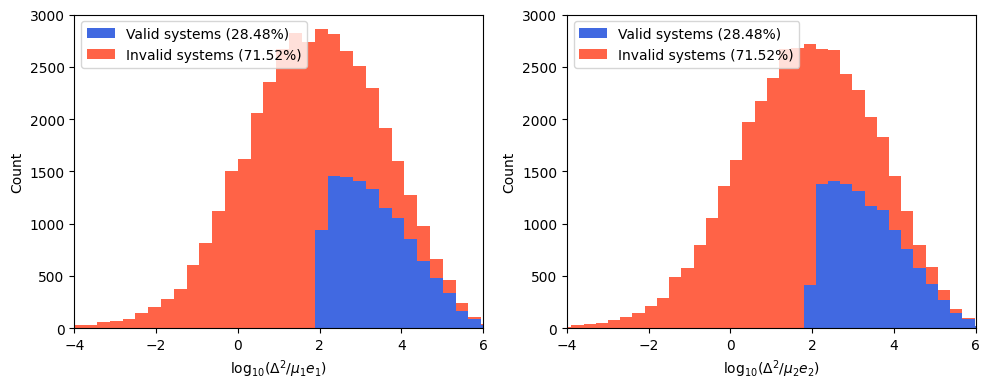

In [14]:
# Histogram of validity condition
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fmt = lambda x: f"{x:.2f}".rstrip("0").rstrip(".")
labels = [f"Valid systems ({fmt(valid_percent)}%)", f"Invalid systems ({fmt(100-valid_percent)}%)"]
colors = ["royalblue", "tomato"]
xlim = (-4, 6); ylim = (0, 3000)

# Left histogram
ax[0].hist([np.log10(validity1[valid]), np.log10(validity1[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[0].set_xlabel('log$_{10}$($\Delta^2 / \mu_1 e_1$)')
ax[0].set_ylabel('Count')
ax[0].set_xlim(xlim); ax[0].set_ylim(ylim)
ax[0].legend(loc='upper left')

# Right histogram
ax[1].hist([np.log10(validity2[valid]), np.log10(validity2[~valid])],
           bins=50, stacked=True, label=labels, color=colors)
ax[1].set_xlabel('log$_{10}$($\Delta^2 / \mu_2 e_2$)')
ax[1].set_ylabel('Count')
ax[1].set_xlim(xlim); ax[1].set_ylim(ylim)
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
# Export dataframe
df.to_csv("lithwick_TTVFast_params.csv", index=False)